In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest


Создаем Таб с транзакциями и Таб с клиентскими данными

In [174]:
# Устанавливаем параметры генерации данных
np.random.seed(42)  # для воспроизводимости
num_clients = 100000

# Таблица 1: покупки клиентов за октябрь 2024
dates_october = pd.date_range(start="2024-10-01", end="2024-10-31")
client_ids = np.arange(1, num_clients + 1)
num_purchases = np.random.randint(0, 10, size=num_clients)  # число покупок для каждого клиента

# Генерация данных о покупках
purchase_data = []
for client_id, purchases in zip(client_ids, num_purchases):
    for _ in range(purchases):
        purchase_data.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500), 2),  # сумма покупки в диапазоне 5-500
            "purchase_date": np.random.choice(dates_october)  # случайная дата октября
        })

dfp = pd.DataFrame(purchase_data)
print(dfp.head(10))

# Таблица 2: клиентские данные
dfc = pd.DataFrame({
    "client_id": client_ids,
    "age": np.random.randint(18, 70, size=num_clients),  # возраст клиента
    "gender": np.random.choice(["male", "female"], size=num_clients),  # пол клиента
    "region": np.random.choice(["North", "South", "East", "West"], size=num_clients),  # регион проживания
    "income": np.random.randint(20000, 150000, size=num_clients),  # годовой доход
    "loyalty_score": np.random.uniform(0, 1, size=num_clients)  # уровень лояльности (0-1)
})
print(dfc.head(10))

   client_id  purchase_amount purchase_date
0          1           196.40    2024-10-23
1          1           213.69    2024-10-04
2          1           328.97    2024-10-23
3          1            74.69    2024-10-31
4          1           328.36    2024-10-29
5          1           119.29    2024-10-03
6          2           214.57    2024-10-18
7          2           334.12    2024-10-29
8          2           418.48    2024-10-31
9          3           473.66    2024-10-07
   client_id  age  gender region  income  loyalty_score
0          1   44    male   West   68313       0.820694
1          2   53  female  North   91958       0.295158
2          3   63    male  North   60929       0.471122
3          4   52    male  South   52136       0.975606
4          5   49    male   West  108991       0.572810
5          6   53  female  North   64442       0.497322
6          7   66  female   East   41289       0.385184
7          8   61  female  South  126876       0.244793
8          9

In [333]:
# Группируем по client_id и считаем сумму покупок для каждого клиента
dfp_inc = dfp.groupby('client_id')['purchase_amount'].sum().reset_index()
# Переименовываем столбец для удобства
dfp_inc.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)

dfp_cnt = dfp.groupby('client_id')['purchase_amount'].count().reset_index()
# Переименовываем столбец для удобства
dfp_cnt.rename(columns={'purchase_amount': 'total_purchase_count'}, inplace=True)

# Выводим первые 5 строк для проверки
print(dfp_inc.head())
print(dfp_cnt.head())

   client_id  total_purchase_amount
0          1                1261.40
1          2                 967.17
2          3                1770.06
3          4                1382.90
4          5                2482.11
   client_id  total_purchase_count
0          1                     6
1          2                     3
2          3                     7
3          4                     4
4          5                     6


In [337]:
print(dfp_inc.total_purchase_amount.agg(["count", "median", "mean", "std", "max"]))
print(dfp_cnt.total_purchase_count.agg(["count", "median", "mean", "std", "max"]))

count     90026.000000
median     1225.510000
mean       1268.114427
std         726.981685
max        3805.160000
Name: total_purchase_amount, dtype: float64
count     90026.000000
median        5.000000
mean          5.015840
std           2.581668
max           9.000000
Name: total_purchase_count, dtype: float64


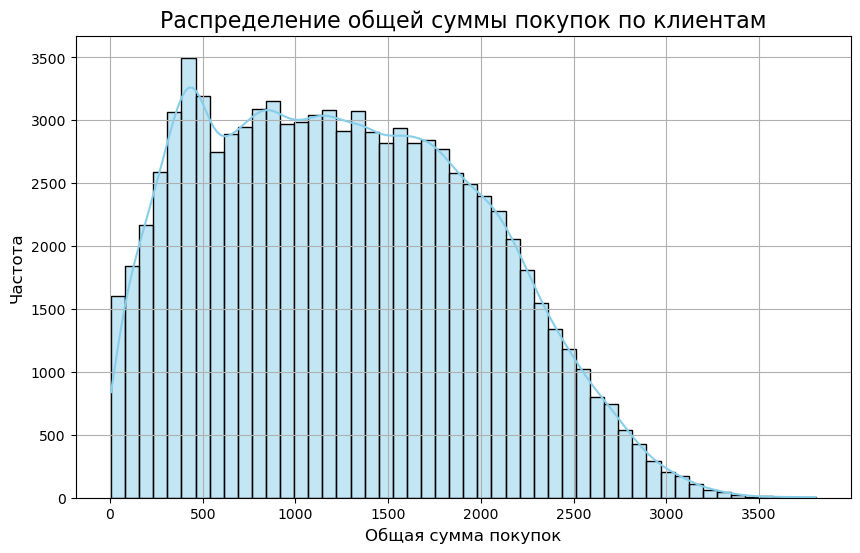

In [293]:
# Строим гистограмму распределения общей суммы покупок
plt.figure(figsize=(10, 6))
sns.histplot(dfp_inc['total_purchase_amount'], kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

In [347]:
import statsmodels.stats as sms
# Параметры
alpha = 0.05  # уровень значимости
power = 0.8   # мощность теста
effect_size = 0.05  # МДЕ в процентах
baseline_mean = dfp_inc.total_purchase_amount.mean()  # средняя выручка
std_dev = dfp_inc.total_purchase_amount.std()  # стандартное отклонение

print('std =', std_dev)
z_alpha = norm.ppf(1 - alpha / 2)
z_beta = norm.ppf(power)  
print(z_alpha)
print(z_beta)
# Расчет минимального эффекта (в абсолютных единицах)
md_effect = baseline_mean * effect_size
print(md_effect)
# Расчет эффекта в терминах стандартного отклонения (Cohen's d)
cohen_d = md_effect / std_dev
print(cohen_d)
# Расчет размера выборки для двухвыборочного t-теста
sample_size = sms.power.TTestIndPower().solve_power(effect_size=cohen_d, alpha=alpha, power=power, alternative='two-sided')

# Вывод размера выборки
print(f"Необходимый размер выборки для каждой группы: {round(sample_size)}")

std = 726.9816848259933
1.959963984540054
0.8416212335729143
63.40572134161243
0.08721776994531699
Необходимый размер выборки для каждой группы: 2065


In [351]:
from scipy.stats import norm

def calculate_sample_size(sigma, delta, alpha=0.05, power=0.8):
    z_alpha = norm.ppf(1 - alpha / 2)  # z-значение для уровня значимости
    print(z_alpha)
    z_beta = norm.ppf(power)          # z-значение для мощности
    print(z_beta)
    n = (2 * (z_alpha + z_beta)**2 * sigma**2) / delta**2
    print(n)
    print(delta)
    return int(n) + 1  # Округляем вверх

# Пример:
sigma = 727   # стандартное отклонение
delta = 63.4 # минимально значимое различие в абсолюте

sample_size = calculate_sample_size(sigma, delta)
print(f"Требуемый размер выборки для каждой группы: {sample_size}")

1.959963984540054
0.8416212335729143
2064.0868936479565
63.4
Требуемый размер выборки для каждой группы: 2065


In [361]:
from scipy.stats import norm

def calculate_sample_size(sigma, delta, alpha=0.05, power=0.8):
    z_alpha = norm.ppf(1 - alpha / 2)  # z-значение для уровня значимости
    print(z_alpha)
    z_beta = norm.ppf(power)          # z-значение для мощности
    print(z_beta)
    n = (2 * (z_alpha + z_beta)**2 * sigma**2) / delta**2
    print(n)
    print(delta)
    return int(n) + 1  # Округляем вверх

# Пример:
sigma = dfp_inc.total_purchase_amount.std()   # стандартное отклонение
delta = 0.05 * dfp_inc.total_purchase_amount.mean() # минимально значимое различие в абсолюте

sample_size = calculate_sample_size(sigma, delta)
print(f"Требуемый размер выборки для каждой группы: {sample_size}")

1.959963984540054
0.8416212335729143
2063.6104292610057
63.40572134161243
Требуемый размер выборки для каждой группы: 2064


Переходим к формированию групп.
Для формирования максимально похожих групп воспользуемся методом кластеризации.

[[ 0.03946591 -0.44538894  1.11768216]
 [ 0.63994127  0.18401012 -0.7047995 ]
 [ 1.30713611 -0.64194139 -0.09458185]
 ...
 [-0.02725357  1.61556358 -1.36099188]
 [-0.96132636  1.00410552  0.6471559 ]
 [ 0.30634385 -1.53390727 -0.22580575]]


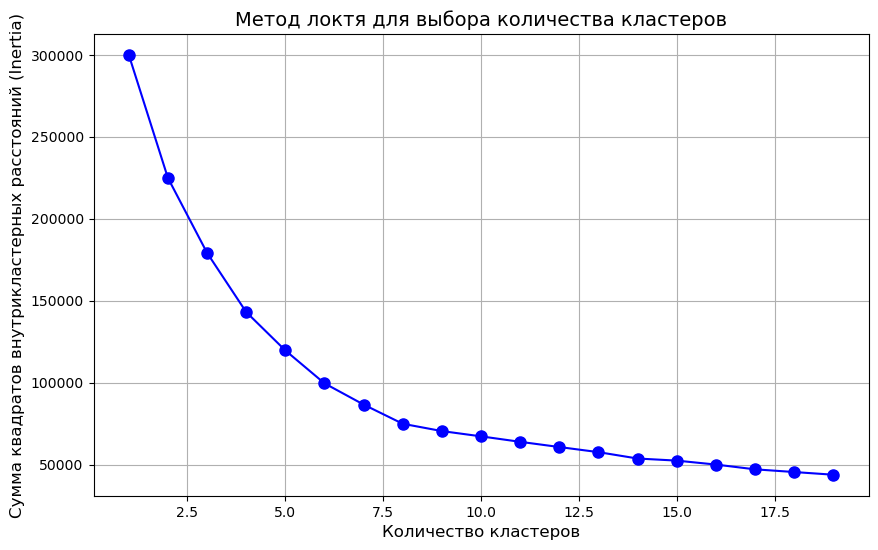

In [136]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

# Загружаем данные о клиентах

# Подготовка данных для кластеризации
numeric_columns = ["age", "income", "loyalty_score"]  # числовые столбцы для кластеризации
data_for_clustering = dfc[numeric_columns]
#print(data_for_clustering.head(10))

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)
print(scaled_data)
# Метод локтя для определения количества кластеров
inertia = []  # Список для хранения суммы квадратов внутрикластерных расстояний
k_range = range(1, 20)  # Диапазон возможных кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Сумма квадратов внутрикластерных расстояний (Inertia)', fontsize=12)
plt.title('Метод локтя для выбора количества кластеров', fontsize=14)
plt.grid(True)
plt.show()


In [267]:
# Кластеризация (выбираем 10 кластеров как пример)
kmeans = KMeans(n_clusters=10, random_state=42)
dfc['cluster'] = kmeans.fit_predict(scaled_data)
#print(dfc.head(10))
# Разделение клиентов на группы A и B
group_A = []
group_B = []

# Равномерное распределение клиентов из каждого кластера
for cluster_id in dfc['cluster'].unique():
    cluster_clients = dfc[dfc['cluster'] == cluster_id]
    #if cluster_id == 1:
        #print(cluster_clients.head(10))
    sampled_clients = cluster_clients.sample(n=20000 // 10, random_state=42)  # Пропорционально числу кластеров
    half = len(sampled_clients) // 2
    
    group_A.extend(sampled_clients.iloc[:half]['client_id'].tolist())
    group_B.extend(sampled_clients.iloc[half:]['client_id'].tolist())

# Проверка итоговых размеров групп
print('Sizes',len(group_A), len(group_B))
#print(group_A[:10],group_B[:10])

group_A_df = dfc[dfc['client_id'].isin(group_A)]
group_B_df = dfc[dfc['client_id'].isin(group_B)]

group_A_df = group_A_df.merge(dfp_inc, on='client_id', how='left')
group_B_df = group_B_df.merge(dfp_inc, on='client_id', how='left')

# Просмотр первых 5 строк для каждой группы
print(group_A_df.total_purchase_amount.mean(),'\n', group_B_df.total_purchase_amount.mean())

Sizes 10000 10000
1283.0431932773108 
 1261.7873978065802


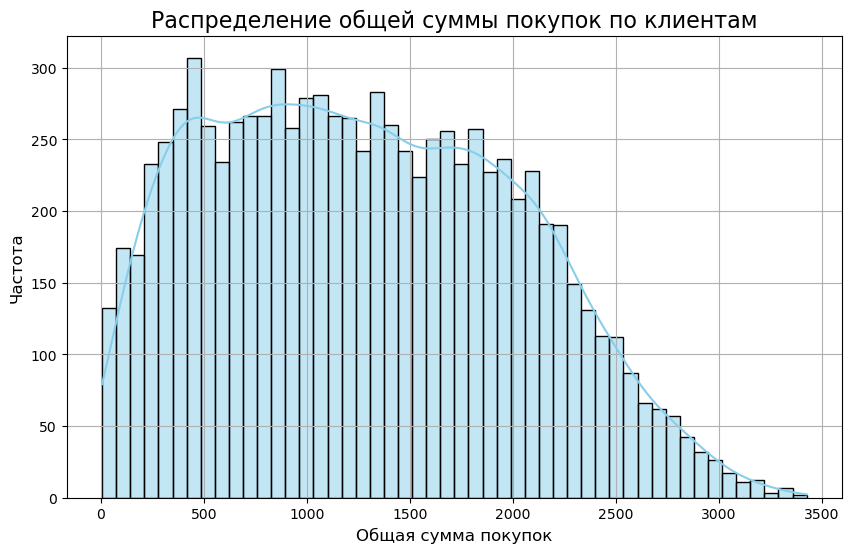

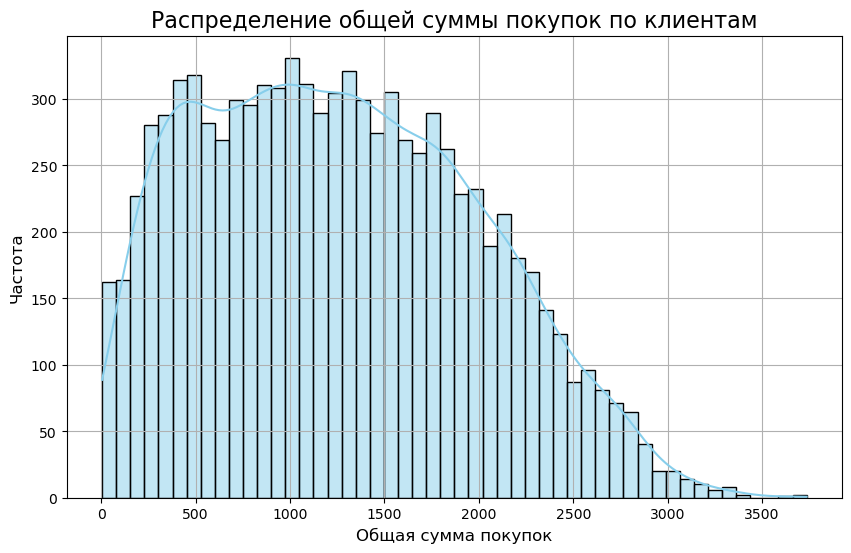

In [269]:
# Строим гистограмму распределения общей суммы покупок группы А
plt.figure(figsize=(10, 6))
sns.histplot(group_A_df.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

# Строим гистограмму распределения общей суммы покупок группы Б
plt.figure(figsize=(10, 6))
sns.histplot(group_B_df.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

In [271]:
# Параметры
dates_range = pd.date_range(start="2024-11-01", end="2024-11-14")  # Для двух недель
num_clients_A = len(group_A)  # Количество клиентов в группе A
num_clients_B = len(group_B)  # Количество клиентов в группе B

# Генерация покупок для группы A
purchase_data_A = []
for client_id in group_A:
    num_purchases = np.random.randint(1, 10)  # случайное количество покупок (от 1 до 10)
    for _ in range(num_purchases):
        purchase_data_A.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500), 2),  # случайная сумма покупки
            "purchase_date": np.random.choice(dates_range)  # случайная дата
        })

# Генерация покупок для группы B (с увеличением суммы покупок на 6%)
purchase_data_B = []
for client_id in group_B:
    num_purchases = np.random.randint(1, 10)  # случайное количество покупок (от 1 до 10)
    for _ in range(num_purchases):
        purchase_data_B.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500) * 1.1, 2),  # увеличение суммы на 6%
            "purchase_date": np.random.choice(dates_range)  # случайная дата
        })

# Создаем DataFrame для покупок группы A и B

df_A = pd.DataFrame(purchase_data_A)
df_B = pd.DataFrame(purchase_data_B)

dfp_inc_A = df_A.groupby('client_id')['purchase_amount'].sum().reset_index()
dfp_inc_A.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)
dfp_inc_B = df_B.groupby('client_id')['purchase_amount'].sum().reset_index()
dfp_inc_B.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)

# Проверим, как выглядят данные
print(dfp_inc_A.head(10))
print(dfp_inc_B.head(10))



   client_id  total_purchase_amount
0          2                1168.67
1          5                2374.50
2         17                1627.90
3         26                2134.72
4         37                2083.05
5         89                2317.11
6         92                2159.68
7         93                1882.82
8        101                2352.62
9        109                2901.15
   client_id  total_purchase_amount
0          1                 944.18
1          3                 855.47
2          9                1658.64
3         10                 594.93
4         11                1705.55
5         12                2116.95
6         14                2026.46
7         18                2702.78
8         28                1149.39
9         33                1214.54


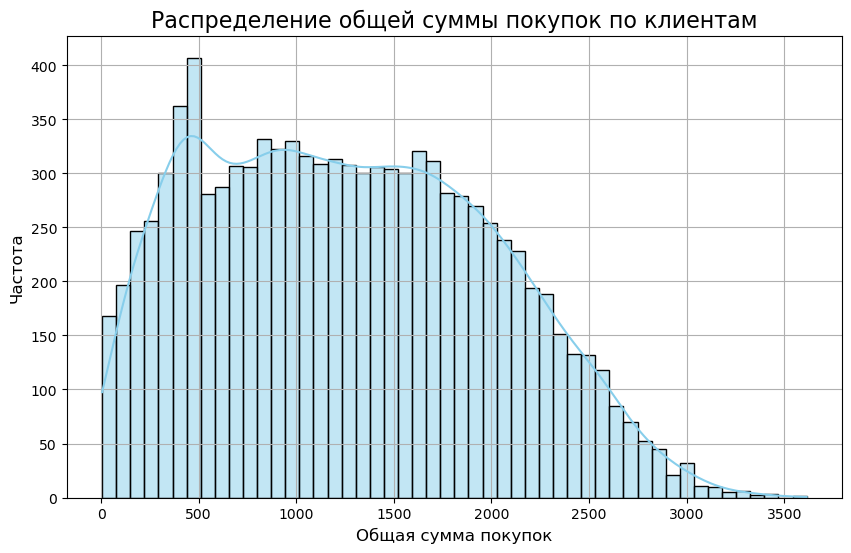

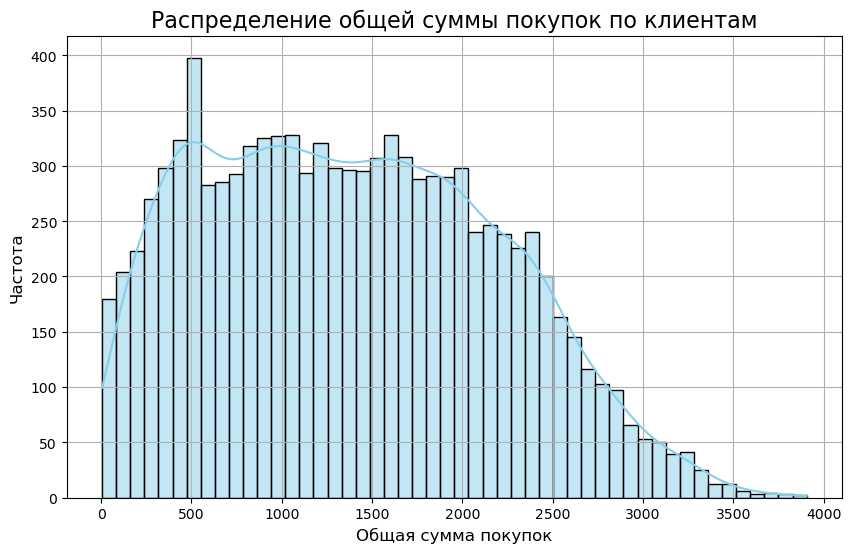

In [273]:
# Строим гистограмму распределения общей суммы покупок группы А
plt.figure(figsize=(10, 6))
sns.histplot(dfp_inc_A.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

# Строим гистограмму распределения общей суммы покупок группы Б
plt.figure(figsize=(10, 6))
sns.histplot(dfp_inc_B.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

Проводим тест Шапиро для проверки на нормальность распределений

In [276]:
test_stat_A, pvalue_A = shapiro(dfp_inc_A.total_purchase_amount)
print('Group A - Test Stat = %.4f, p-value = %.4f' % (test_stat_A, pvalue_A))

# Тест Шапиро для группы B
test_stat_B, pvalue_B = shapiro(dfp_inc_B.total_purchase_amount)
print('Group B - Test Stat = %.4f, p-value = %.4f' % (test_stat_B, pvalue_B))

Group A - Test Stat = 0.9743, p-value = 0.0000
Group B - Test Stat = 0.9749, p-value = 0.0000


C:\Users\junte\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


Тест Левена для проверки гомогенности дисперсий

In [279]:
test_stat, pvalue = levene(dfp_inc_A.total_purchase_amount, dfp_inc_B.total_purchase_amount)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 106.2728, p-value = 0.0000


In [281]:
test_stat, pvalue = mannwhitneyu(dfp_inc_A.total_purchase_amount,dfp_inc_B.total_purchase_amount)
print('Test Stat %.4f, p-value %.4f' % (test_stat, pvalue))

Test Stat 46006354.5000, p-value 0.0000


In [283]:
print(dfp_inc_A.total_purchase_amount.head(10))

0    1168.67
1    2374.50
2    1627.90
3    2134.72
4    2083.05
5    2317.11
6    2159.68
7    1882.82
8    2352.62
9    2901.15
Name: total_purchase_amount, dtype: float64


In [285]:
def AB_Test():
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dfp_inc_A['total_purchase_amount']
    groupB = dfp_inc_A['total_purchase_amount']
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test()

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



C:\Users\junte\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,1.0,A/B groups are similar!


In [287]:
dfp_inc_A['total_purchase_amount'].std()

727.6334481915187

In [289]:
dfp_inc_B['total_purchase_amount'].mean()

1386.2206420000002

In [365]:
quantile_95 = norm.ppf(0.95, loc=50, scale=30)
print(f"95%-квантиль: {quantile_95}")

95%-квантиль: 99.34560880854417
